In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings
import math
import nltk
from matplotlib.patches import Rectangle
warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNHD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/GSHD_HN01/outdir/sc_bulk_BCR_data_analysis_v0.1"

bulk_project = "240826_BSimons"
sc_project = "240805_BSimons"
PROJECTS = f"{bulk_project}_{sc_project}"
mouseid = "m2"

dist_type = "full_seq"
path_to_01_output = f"{outdir}/tree_analysis/{bulk_project}/01_output"
path_to_06_output = f"{outdir}/tree_analysis/06_output/{PROJECTS}/{mouseid}/{dist_type}"
path_to_10_output = f"{outdir}/tree_analysis/10_output/{PROJECTS}/{mouseid}/{dist_type}"
os.system(f"mkdir -p {path_to_10_output}")

with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
    saveTreeobj = pickle.load(f)

maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")
maindf = maindf[maindf["mouseID"] == mouseid]

/home/hieunguyen/miniconda3/envs/ete3_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
if os.path.isfile(os.path.join(path_to_10_output, "tree_dist_plotdf.csv")) == False:
    treedf = pd.DataFrame()
    for cloneid in tqdm(maindf["cloneid"].unique()):
        # cloneid = "m3_IGHV1-12-01_IGHJ3-01_27_1"
        os.system(f"mkdir -p {path_to_06_output}/{cloneid}")
        V_gene = cloneid.split("_")[1]
        J_gene = cloneid.split("_")[2]
        cdr3_len = cloneid.split("_")[3]
        mouseid = cloneid.split("_")[0]

        if os.path.isfile(os.path.join(path_to_06_output, cloneid, f"tree_Seqdf_{cloneid}.csv")) == True:
            dist2sc_org = pd.read_csv(os.path.join(path_to_06_output, cloneid, f"tree_Seqdf_{cloneid}.csv"), index_col = [0])

            treeobj = saveTreeobj[cloneid]
            seqdf = treeobj.seqdf.copy()
            idmapdf = treeobj.idmapseqdf.copy()
            seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")

            df = pd.DataFrame(data = seqdf.seqid.unique(), columns = ["seqid"])
            df["mouseid"] = mouseid
            df["cloneID"] = cloneid

            df["dist_to_root"] = df["seqid"].apply(lambda x: treeobj.node_depth(node = [item for item in treeobj.nodes if item.name == x][0], topo = False))
            df["topo_dist_to_root"] = df["seqid"].apply(lambda x: treeobj.node_depth(node = [item for item in treeobj.nodes if item.name == x][0], topo = True))

            deepest_node = df[df["dist_to_root"] == df["dist_to_root"].max()].seqid.unique()[0]

            df["dist_to_deepest"] = df["seqid"].apply(lambda x: treeobj.tree.get_distance(x, deepest_node) if x != deepest_node else 0)
            df["topo_dist_to_deepest"] = df["seqid"].apply(lambda x: treeobj.tree.get_distance(x, deepest_node, topology_only= True) if x != deepest_node else 0)

            def get_node_furthest_child(x, topo):
                output = treeobj.tree.search_nodes(name=x)[0].get_farthest_leaf(topology_only= topo)
                return output[0].name, output[1]
            df[['topo_furthest_child_node', 'topo_dist_to_furthest_child_node']] = df['seqid'].apply(
                lambda x: pd.Series(
                    get_node_furthest_child(x, True)))
            df[['furthest_child_node', 'dist_to_furthest_child_node']] = df['seqid'].apply(
                lambda x: pd.Series(
                    get_node_furthest_child(x, False)))

            change_name = {
                "dist_to_root": "rootness",
                "topo_dist_to_root": "topo_rootness",
                "dist_to_furthest_child_node": "leafness",
                "topo_dist_to_furthest_child_node": "topo_leafness"
            }

            df.columns = [change_name[item] if item in change_name.keys() else item for item in df.columns]
            df["num_node"] = len(treeobj.nodes)
            df_org = df.copy()

            dist2sc = dist2sc_org[dist2sc_org.columns[4:]].drop(["aaSeqCDR3", "cloneid"], axis = 1)
            dist2sc = dist2sc[dist2sc["seqid"].duplicated() == False]
            dfmerge = df.merge(dist2sc, right_on = "seqid", left_on = "seqid")

            dfmerge = dfmerge.drop([item for item in dfmerge.columns if "-1" in item], axis = 1)
            treedf = pd.concat([treedf, dfmerge], axis = 0)
    treedf.to_csv(os.path.join(path_to_10_output, "tree_dist_plotdf.csv"), index = False)
else:
    treedf = pd.read_csv(os.path.join(path_to_10_output, "tree_dist_plotdf.csv"))

treedf = treedf.sort_values(by = "num_node", ascending = False)

countdf = treedf[["cloneID", "num_node"]].copy()
countdf = countdf[countdf["cloneID"].duplicated() == False]

selected_clones = countdf.head(100).cloneID

In [34]:
treedf["match_sc"] = treedf[["cloneID", "min_dist_to_a_cell"]].apply(
    lambda x: "top1-closest" if x[1] == treedf[treedf["cloneID"] == x[0]]["min_dist_to_a_cell"].min() else "others", axis = 1)

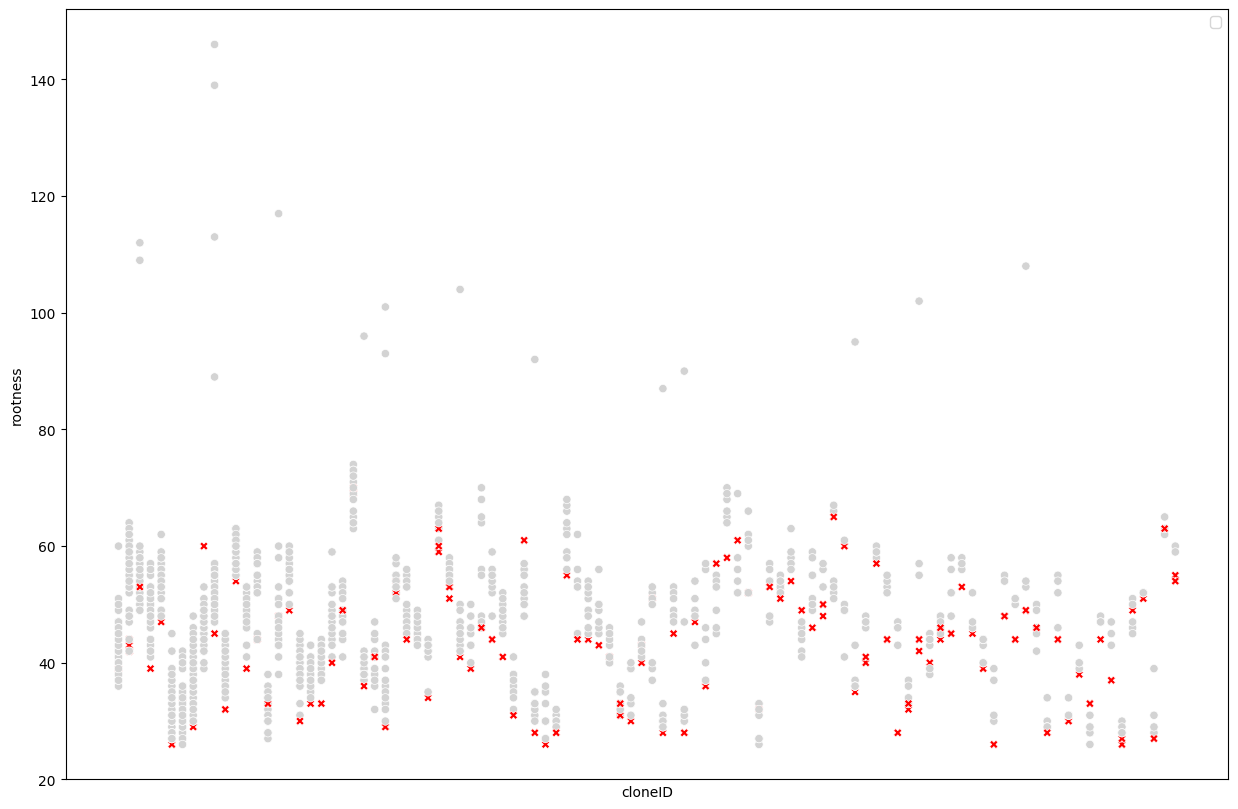

In [35]:
plt.figure(figsize= (15, 10))
palette = {
    'top1-closest': 'red',
    'others': 'lightgray'
}
plotdf = treedf[treedf["cloneID"].isin(selected_clones)]

sns.scatterplot(plotdf, x = "cloneID", y = "rootness", hue = "match_sc", style= "match_sc", palette = palette)
plt.legend([])
plt.xticks([])
plt.show()